# sdsde Library

This library SDSDE (Simplify Data Science and Data Engineering) is a library that focuses on making Data Science and Data Engineering tasks much easier for the masses this is a pre-release so this isn't a pypi library, but I plan on spending time improving this and releasing this as a tool that will help organizations that are Snowflake, Azure and Gitlab focused.

This template approach can easily be transfered to other clouds, but would need time and focus to make sure this was possible. Hope this is something someone finds and is happy take code from this that makes their lives much easier in the future.

Inside of this library you will have all the tools needed to move data from azure datalakes and snowflake to help build Full Data Science Pipelines.

I am planning on releasing a template example of this with a kaggle example similar to below expect I will focus on treating the Kaggle API as the ingestion point to azure datalake and then move that data to snowflake to be queried from a feature store and then modeled and create model inference against the test set.

What you will learn from that template is that one can iterate quickly and get a full Data Science Pipeline out the door in less than a day. This way business uses

# How to Install sdsde Library

```bash
pip install sdsde
```

# Kaggle Examples

In [14]:
#skip
import logging
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import gc

from sdsde.modeling.inference import pull_sklearn_object_from_data_lake, \
                                    push_dataframe_to_data_lake_as_parquet, move_parquet_table_to_snowflake, \
                                    query_and_push_feature_set_to_data_lake
from sdsde.modeling.inferencefastai import (
    pull_fastai_learner_from_data_lake, pull_transform_predict_sklearn, pull_fastai_preprocess_from_data_lake,
    push_prediction_to_dl_and_sf
)
from sdsde.modeling.premodel import make_data_lake_stage, temporal_and_static_dump_data_to_datalake
from sdsde.modeling.preprocessingfastai import generate_fastai_pytorch_dataloader, load_pandas, save_fastai_preprocess_to_data_lake
from sdsde.modeling.premodel import query_pushed_parquet_table_data_lake, query_feature_set_from_data_lake
from sdsde.modeling.training import HpOptBinary, save_sklearn_object_to_data_lake
from sdsde.modeling.trainingfastai import train_fastai_tabular_model, save_fastai_model_to_data_lake
from sdsde.snowflake.query import SnowflakeConnect
from sdsde.azure.filehandling import FileHandling
from sdsde.utils.traininghelpers import  binary_classification_reporter_sklearn
from sdsde.utils.traininghelpersfastai import binary_classification_reporter_fastai_dl, change_dl_to_pandas_df
from fastai.tabular.core import CategoryBlock, Categorify, FillMissing, Normalize
from fastai.basics import *
from fastai.tabular.all import *
from hyperopt import fmin, tpe, STATUS_OK, Trials, hp, space_eval
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split


logging.basicConfig(level=logging.INFO)
logging.getLogger("azure.core").setLevel(logging.WARNING)
logging.getLogger("urllib3.connectionpool").setLevel(logging.CRITICAL)
logging.getLogger("snowflake.connector").setLevel(logging.WARNING)
logger = logging.getLogger(__name__)

This approach will not win you a Kaggle Competition, but it will get you a baseline and allow you to iterate quickly and get quick feed back from Kaggle to know if what you are doinng is making a difference.

## Binary Classification Classic Titanic

In [160]:
#skip
! kaggle competitions list -s titanic

ref      deadline             category            reward  teamCount  userHasEntered  
-------  -------------------  ---------------  ---------  ---------  --------------  
titanic  2030-01-01 00:00:00  Getting Started  Knowledge      13982            True  


In [161]:
#skip

! kaggle competitions submissions  -c titanic

fileName          date                 description    status    publicScore  privateScore  
----------------  -------------------  -------------  --------  -----------  ------------  
titantic_sub.csv  2022-02-03 19:31:30  Quick Xgboost  complete  0.73444      None          
titantic_sub.csv  2022-02-03 19:27:28  Auto Fastai    complete  0.74401      None          


In [121]:
#skip

!kaggle competitions download -c titanic

! unzip titanic.zip

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 8.58MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### DL Method Tabluar

In [122]:
#skip

df = pd.read_csv('train.csv')

logger.info(f'Size of data set: {df.shape}')

# quick feature eng
def feature_create(df):
    df['Fare_Bucket'] = pd.qcut(df['Fare'], 13)
    df['Age'] = pd.qcut(df['Age'], 10)
    df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Is_Married'] = 0
    df['Is_Married'] = np.where(df.Title == 'Mrs', 1, 0)
    return df
df = feature_create(df)
df.loc[df.sample(frac=0.05).index, 'Fare'] = np.nan
display(df.head(3))

INFO:__main__:Size of data set: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Bucket,Ticket_Frequency,Title,Is_Married
0,1,0,3,"Braund, Mr. Owen Harris",male,"(19.0, 22.0]",1,0,A/5 21171,7.2500,NaN,S,"(7.229, 7.75]",1,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,"(36.0, 41.0]",1,0,PC 17599,71.2833,C85,C,"(55.9, 83.158]",1,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,"(25.0, 28.0]",0,0,STON/O2. 3101282,7.9250,NaN,S,"(7.896, 8.05]",1,Miss,0


INFO:sdsde.modeling.preprocessingfastai:Training Data Size 713
INFO:sdsde.modeling.preprocessingfastai:Validation Data Size 178
INFO:sdsde.modeling.preprocessingfastai:Categorical Variable(s) For Project ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Fare_Bucket', 'Ticket_Frequency', 'Title', 'Is_Married']
INFO:sdsde.modeling.preprocessingfastai:Continuous Variable(s) For Project ['Fare']
INFO:sdsde.modeling.preprocessingfastai:Dependent Variable(s) For Project ['Survived']
INFO:sdsde.modeling.preprocessingfastai:dataloader being created
INFO:sdsde.modeling.preprocessingfastai:   Pclass  Name  Sex  Age  SibSp  Parch  Ticket  Cabin  Embarked  Fare_Bucket  \
0       3   109    2    3      2      1     524      0         3            2   
3       1   273    1    7      2      1      50     56         3           11   
4       3    16    2    7      1      1     473      0         3            4   
8       3   413    1    5      1      3     345      0  

/home/azureuser/miniconda3/envs/dsde_upgrade/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)
INFO:sdsde.modeling.trainingfastai:Learning Rate Suggestion SuggestedLRs(valley=0.001737800776027143)


epoch,train_loss,valid_loss,recall_score,accuracy,f1_score,roc_auc_score,balanced_accuracy_score,time
0,0.628193,0.661324,0.000000,0.601124,0.000000,0.748848,0.500000,00:00
1,0.477936,0.611730,0.014085,0.606742,0.027778,0.874292,0.507042,00:00
2,0.329095,0.468887,0.591549,0.797753,0.700000,0.873239,0.763064,00:00
3,0.216401,0.449692,0.732394,0.780899,0.727273,0.869817,0.772739,00:00
4,0.152425,0.447413,0.718310,0.786517,0.728571,0.869817,0.775043,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.5.


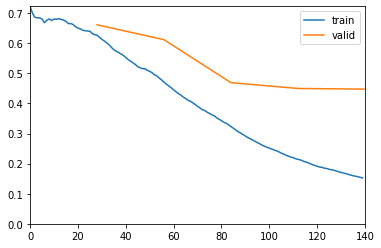

Better model found at epoch 1 with balanced_accuracy_score value: 0.5070422535211268.
Better model found at epoch 2 with balanced_accuracy_score value: 0.7630643675134922.
Better model found at epoch 3 with balanced_accuracy_score value: 0.7727392391733579.
Better model found at epoch 4 with balanced_accuracy_score value: 0.7750427800447546.


INFO:root:Percent Predicted Set 0.388%
INFO:root:Percent Predicted Set at 0.5 threshold 0.388%


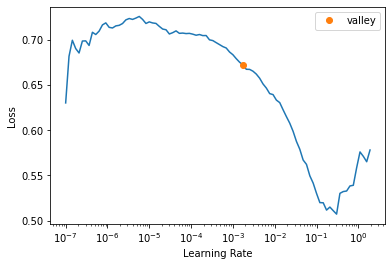

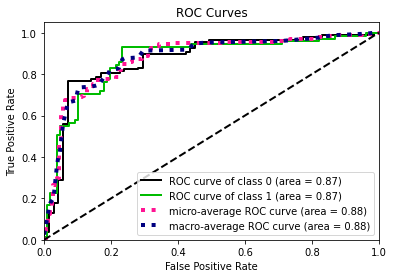

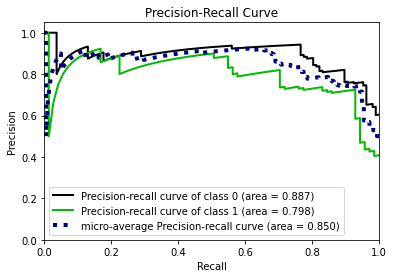

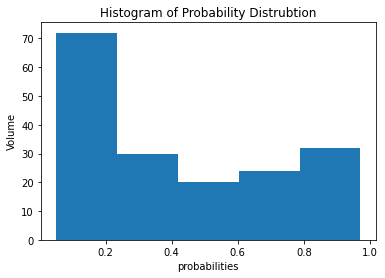

INFO:root:Percent Return Actual Set 0.399%
INFO:root:Accuracy For Each Class
INFO:root:[0.8317757  0.71830986]
INFO:root:[[89 18]
 [20 51]]
INFO:root:              precision    recall  f1-score   support

           0       0.82      0.83      0.82       107
           1       0.74      0.72      0.73        71

    accuracy                           0.79       178
   macro avg       0.78      0.78      0.78       178
weighted avg       0.79      0.79      0.79       178

INFO:root:Accuracy For Each Class 0.4 Cut Off for Model
INFO:root:[0.8317757  0.71830986]
INFO:root:[[89 18]
 [20 51]]
INFO:root:              precision    recall  f1-score   support

           0       0.82      0.83      0.82       107
           1       0.74      0.72      0.73        71

    accuracy                           0.79       178
   macro avg       0.78      0.78      0.78       178
weighted avg       0.79      0.79      0.79       178

INFO:root:AUC 0.8698170330393578


(0.8698170330393578, 0.7750427800447546)

In [123]:
#skip

cat_vars = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
            'Ticket', 'Cabin', 'Embarked', 'Fare_Bucket',
            'Ticket_Frequency', 'Title', 'Is_Married']
cont_vars = ['Fare']
y_var = ['Survived']

dl_train, tab_train = generate_fastai_pytorch_dataloader(df, cat_vars=cat_vars, cont_vars=cont_vars, 
                                                         y_var=y_var, y_block=CategoryBlock(), y_range=None,
                                                         val_pct=0.2, bs=25, procs = [Categorify, FillMissing, Normalize],
                                                         seed=123, splits=None)

learn, probs, y, loss = train_fastai_tabular_model(dl = dl_train, 
                                                   layer_sizes = [50, 10],
                                                   metrics = [Recall(), accuracy, F1Score(), RocAucBinary(), BalancedAccuracy()],
                                                   epochs = 5,
                                                   wd=0.2,
                                                   model_name = 'sdsde_test_dl_model_fast.pkl',
                                                   save_metric_monitor = 'balanced_accuracy_score',
                                                   save_comp = np.greater,
                                                   early_metric_monitor = 'balanced_accuracy_score',
                                                   early_comp = np.greater,
                                                   early_min_delta = 1e-5,
                                                   patience = 5,
                                                   project_location='projects/model-runs/latest/classification/models/dl/',
                                                   y_range = None, # for regression
                                                   plot=True)

# Uncomment line below to review model arch if you are interested in seeing what a NN arch looks like
# learn.summary()

binary_classification_reporter_fastai_dl(probs, y=y, threshold=0.5, plot=True, bins=5)

In [124]:
#skip

df_test = pd.read_csv('test.csv')
df_test = feature_create(df_test)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Bucket,Ticket_Frequency,Title,Is_Married
0,892,3,"Kelly, Mr. James",male,"(30.0, 36.0]",0,0,330911,7.8292,NaN,Q,"(7.75, 7.879]",1,Mr,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,"(42.0, 50.0]",1,0,363272,7.0000,NaN,S,"(-0.001, 7.25]",1,Mrs,1
2,894,2,"Myles, Mr. Thomas Francis",male,"(50.0, 76.0]",0,0,240276,9.6875,NaN,Q,"(8.05, 10.5]",1,Mr,0
3,895,3,"Wirz, Mr. Albert",male,"(25.0, 27.0]",0,0,315154,8.6625,NaN,S,"(8.05, 10.5]",1,Mr,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,"(20.0, 22.0]",1,1,3101298,12.2875,NaN,S,"(10.5, 13.0]",1,Mrs,1


In [125]:
#skip

test_dl = learn.dls.test_dl(df_test, with_label=False)
probs, _ = learn.get_preds(dl=test_dl)
# binary_classification_reporter_fastai_dl(probs, y=results.pred, threshold=0.5, plot=True, bins=5)

In [133]:
#skip

sub = pd.DataFrame(df_test.PassengerId.values, columns={'PassengerId'})
sub['Survived'] = np.where(probs.numpy()[:, 1] > 0.5, 1, 0)

sub.to_csv('titantic_sub.csv', index=False)

! kaggle competitions submit  -c titanic -f 'titantic_sub.csv' -m 'Auto Fastai'

### Tree Approach

In [141]:
#skip

data_sets = change_dl_to_pandas_df(dl_train)

X_train, y_train, X_valid, y_valid = data_sets

X_train.shape, len(y_train), X_valid.shape, len(y_valid)

INFO:root:Label size 713
INFO:root:Training/Test set shape (713, 15)
INFO:root:Validation set shape (178, 15)
INFO:root:Label size 178


((713, 15), 713, (178, 15), 178)

  0%| | 0/2 [00:00<

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003505 seconds
INFO:hyperopt.tpe:TPE using 0 trials


[12:29:12] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
 50%|▌| 1/2 [00:00<

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003336 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.070028


[12:29:12] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
100%|█| 2/2 [00:01<
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.28,
              enable_categorical=False, eval_metric='auc',
              gamma=3.1785978600773737, gpu_id=0, importance_type=None,
              interaction_constraints=None, learning_rate=0.08365826921723575,
              max_delta_step=None, max_depth=22, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='binary:logitraw',
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.75,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, ...)
[12:29:13] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -

INFO:sdsde.utils.traininghelpers:predicting set
INFO:sdsde.utils.traininghelpers:Percent Return Predicted Set 0.197%
INFO:sdsde.utils.traininghelpers:Percent Return Actual Set 0.399%
INFO:sdsde.utils.traininghelpers:Accuracy For Each Class
INFO:sdsde.utils.traininghelpers:[0.99065421 0.47887324]
INFO:sdsde.utils.traininghelpers:[[106   1]
 [ 37  34]]
INFO:sdsde.utils.traininghelpers:              precision    recall  f1-score   support

           0       0.74      0.99      0.85       107
           1       0.97      0.48      0.64        71

    accuracy                           0.79       178
   macro avg       0.86      0.73      0.74       178
weighted avg       0.83      0.79      0.77       178

INFO:sdsde.utils.traininghelpers:AUC 0.8877846518362512


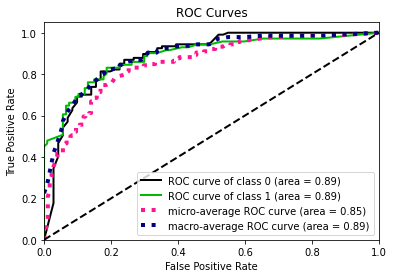

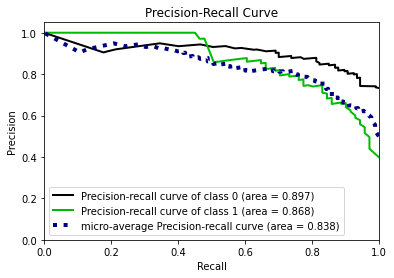

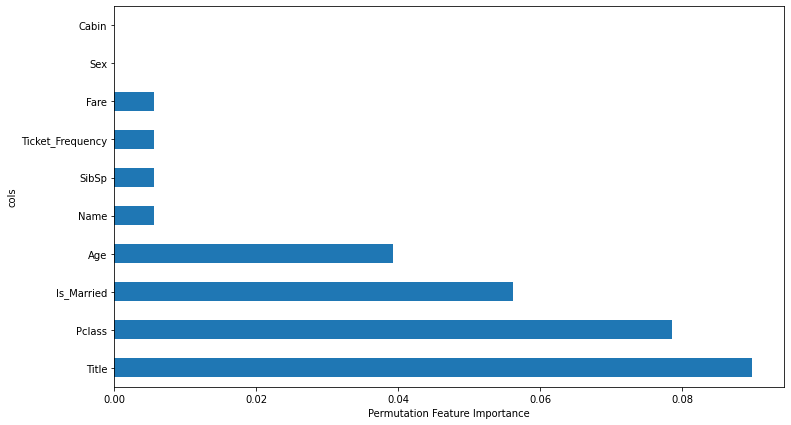

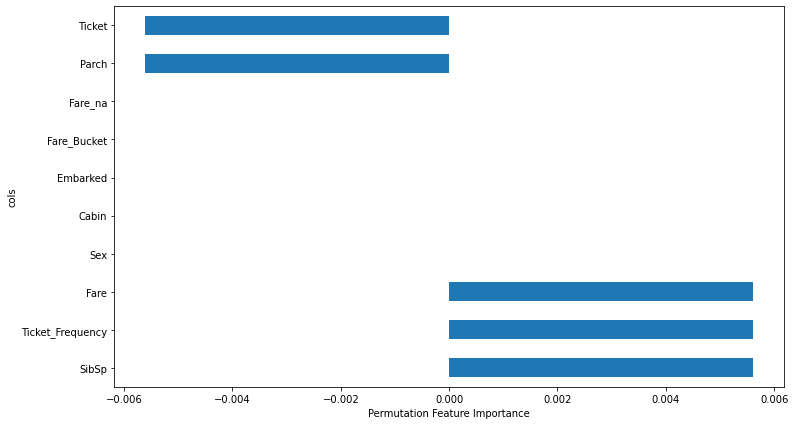

In [142]:
#skip

parameter_space = {
    'max_depth': hp.choice('max_depth', np.arange(21, dtype=int) + 3),
    'gamma': hp.uniform('gamma', 0, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.01),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'objective': hp.choice('objective', ['binary:logistic', 'binary:logitraw', 'binary:hinge']),
    'eval_metric': hp.choice('eval_metric', ['logloss', 'error', 'auc', 'aucpr', 'map']),
    'use_label_encoder': hp.choice('use_label_encoder', [False]),
    'gpu_id': hp.choice('gpu_id', [0]),
}
opt = HpOptBinary(X_train, X_valid, y_train, y_valid, parameter_space=parameter_space)
best = opt.optimize(max_evals=2)
model = xgb.XGBClassifier(**best)
print(model)
eval_set  = [(X_valid, y_valid.values)]
model.fit(X_train, y_train.values, eval_set= eval_set, eval_metric ='auc', early_stopping_rounds = 2)

threshold = 0.5 if model.base_score is None else model.base_score

report = binary_classification_reporter_sklearn(m=model, x=X_valid, y=y_valid, threshold=0.5, 
                                                          plot=True, feature_importance=True)

probs, preds, val_auc, val_bal_acc, fi_permutation = report

In [144]:
#skip

dl_test = tab_train.dnew(df_test)
dl_test.process()

X_test = dl_test.xs

probs = model.predict_proba(X_test)
preds = model.predict(X_test)

sub = pd.DataFrame(df_test.PassengerId.values, columns={'PassengerId'})
sub['Survived'] = np.where(probs[:, 1] > 0.5, 1, 0)

sub.to_csv('titantic_sub.csv', index=False)

In [147]:
#skip

! kaggle competitions submit  -c titanic -f 'titantic_sub.csv' -m 'Quick Xgboost'

100%|██████████████████████████████████████| 2.77k/2.77k [00:01<00:00, 2.01kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [2]:
#skip
file_list = ['test.csv', 'train.csv', 'titantic_sub.csv', 'titanic.zip', 'gender_submission.csv']
for f in file_list:
    if os.path.exists(f):
        os.unlink(f)

## Tabular Playground Series - Oct 2021

In [127]:
#skip

! kaggle competitions list -s 'Tabular Playground Series - Oct 2021'

ref                                 deadline             category      reward  teamCount  userHasEntered  
----------------------------------  -------------------  ----------  --------  ---------  --------------  
tabular-playground-series-oct-2021  2021-10-31 23:59:00  Playground      Swag       1089            True  
hhp                                 2013-04-04 07:00:00  Featured    $500,000       1350           False  


In [128]:
#skip

! kaggle competitions submissions  -c tabular-playground-series-oct-2021

fileName        date                 description                                status    publicScore  privateScore  
--------------  -------------------  -----------------------------------------  --------  -----------  ------------  
playground.csv  2022-02-03 22:49:05  All Columns ROC Metric Follow Data Fastai  complete  0.76327      0.76355       
playground.csv  2022-02-03 22:32:49  More Data Fastai                           complete  0.76415      0.76402       
playground.csv  2022-02-03 22:13:39  Very Little Data Fastai                    complete  0.66276      0.66236       


In [4]:
#skip

!kaggle competitions download -c tabular-playground-series-oct-2021

100%|█████████████████████████████████████▉| 1.28G/1.29G [00:26<00:00, 63.4MB/s]
100%|██████████████████████████████████████| 1.29G/1.29G [00:26<00:00, 52.5MB/s]


In [8]:
#skip

! unzip tabular-playground-series-oct-2021.zip

Archive:  tabular-playground-series-oct-2021.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


lets try a little bigger problem and see how we do on this type of method

In [92]:
#skip

df = pd.read_csv('train.csv')
logger.info(f'Size of data set: {df.shape}')
display(df.head(3))

INFO:__main__:Size of data set: (1000000, 287)


,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
0,0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,...,0,1,0,0,0,0,0,0,0,1
1,1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,...,0,1,0,0,0,0,0,0,0,1
2,2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,...,0,0,0,1,1,0,0,0,0,1


In [106]:
#skip

unique_values = df.iloc[:1000].nunique()
cat_vars = [col for col in  unique_values.index[unique_values < 10] if col!='target']
cont_vars = [col for col in df.columns if col not in cat_vars and col !='id' and col !='target']
y_var = ['target']

In [107]:
#skip

dl_train, tab_train = generate_fastai_pytorch_dataloader(df, cat_vars=cat_vars, cont_vars=cont_vars, 
                                                         y_var=y_var, y_block=CategoryBlock(), y_range=None,
                                                         val_pct=0.2, bs=1025, procs = [Categorify, FillMissing, Normalize],
                                                         seed=123, splits=None)

INFO:sdsde.modeling.preprocessingfastai:Training Data Size 800000
INFO:sdsde.modeling.preprocessingfastai:Validation Data Size 200000
INFO:sdsde.modeling.preprocessingfastai:Categorical Variable(s) For Project ['f22', 'f43', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284']
INFO:sdsde.modeling.preprocessingfastai:Continuous Variable(s) For Project ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', '

INFO:sdsde.modeling.trainingfastai:Learning Rate Suggestion SuggestedLRs(valley=0.002511886414140463)


epoch,train_loss,valid_loss,recall_score,accuracy,f1_score,roc_auc_score,balanced_accuracy_score,time
0,0.497218,0.486757,0.721554,0.761705,0.751746,0.842479,0.761707,01:28
1,0.483159,0.478663,0.717064,0.764260,0.752592,0.847402,0.764262,01:28
2,0.477804,0.476338,0.724074,0.764585,0.754655,0.848321,0.764587,01:28


Better model found at epoch 0 with balanced_accuracy_score value: 0.7617070076542676.


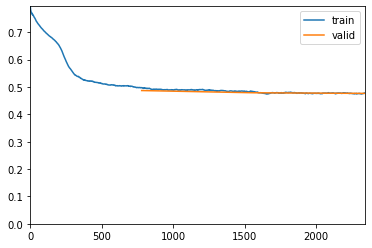

Better model found at epoch 1 with balanced_accuracy_score value: 0.7642623599106559.
Better model found at epoch 2 with balanced_accuracy_score value: 0.7645870256614675.


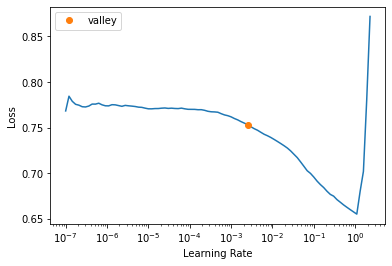

In [110]:
#skip

learn, probs, y, loss = train_fastai_tabular_model(dl = dl_train, 
                                                   layer_sizes = [150, 10],
                                                   metrics = [Recall(), accuracy, F1Score(), RocAucBinary(), BalancedAccuracy()],
                                                   epochs = 3,
                                                   wd=0.2,
                                                   model_name = 'sdsde_test_dl_model_fast.pkl',
                                                   save_metric_monitor = 'balanced_accuracy_score',
                                                   save_comp = np.greater,
                                                   early_metric_monitor = 'balanced_accuracy_score',
                                                   early_comp = np.greater,
                                                   early_min_delta = 1e-5,
                                                   patience = 3,
                                                   tab_config={'embed_p':0.3},
                                                   project_location='projects/model-runs/latest/classification/models/dl/',
                                                   y_range = None, # for regression
                                                   plot=True)

INFO:root:Percent Predicted Set 0.46%
INFO:root:Percent Predicted Set at 0.5 threshold 0.46%


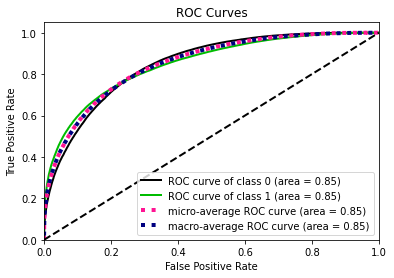

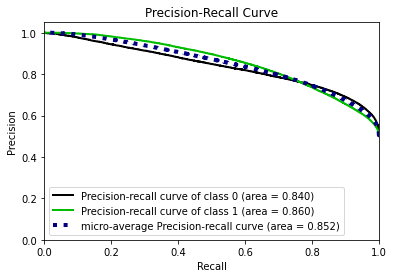

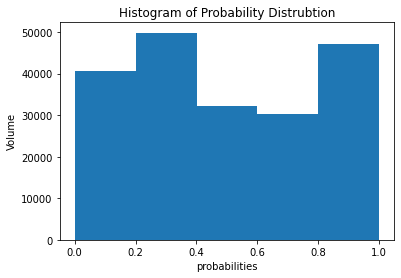

INFO:root:Percent Return Actual Set 0.5%
INFO:root:Accuracy For Each Class
INFO:root:[0.80510026 0.7240738 ]
INFO:root:[[80506 19489]
 [27594 72411]]
INFO:root:              precision    recall  f1-score   support

           0       0.74      0.81      0.77     99995
           1       0.79      0.72      0.75    100005

    accuracy                           0.76    200000
   macro avg       0.77      0.76      0.76    200000
weighted avg       0.77      0.76      0.76    200000

INFO:root:Accuracy For Each Class 0.4 Cut Off for Model
INFO:root:[0.80510026 0.7240738 ]
INFO:root:[[80506 19489]
 [27594 72411]]
INFO:root:              precision    recall  f1-score   support

           0       0.74      0.81      0.77     99995
           1       0.79      0.72      0.75    100005

    accuracy                           0.76    200000
   macro avg       0.77      0.76      0.76    200000
weighted avg       0.77      0.76      0.76    200000

INFO:root:AUC 0.8483214033708035


(0.8483214033708035, 0.7645870256614675)

In [111]:
#skip

# Uncomment line below to review model arch if you are interested in seeing what a NN arch looks like
# learn.summary()

binary_classification_reporter_fastai_dl(probs, y=y, threshold=0.5, plot=True, bins=5)

In [112]:
#skip

test = pd.read_csv('test.csv')
logger.info(f'Size of data set: {df.shape}')

INFO:__main__:Size of data set: (1000000, 287)


In [113]:
#skip

infernece_test = test[cat_vars + cont_vars]
test_dl = learn.dls.test_dl(infernece_test.reset_index(drop=True), with_label=False)
probs, _ = learn.get_preds(dl=test_dl)

In [114]:
#skip

vsub = pd.DataFrame(test.id, columns={'id'})

sub['target'] = np.where(probs[:, 1] > 0.5, 1, 0)

sub.to_csv('playground.csv', index=False)

In [115]:
#skip

! kaggle competitions submit  -c tabular-playground-series-oct-2021 -f 'playground.csv' -m 'All Columns ROC Metric Follow Data Fastai'

100%|██████████████████████████████████████| 4.77M/4.77M [00:00<00:00, 5.80MB/s]
Successfully submitted to Tabular Playground Series - Oct 2021

In [117]:
#skip

! kaggle competitions submissions  -c tabular-playground-series-oct-2021

fileName        date                 description                                status    publicScore  privateScore  
--------------  -------------------  -----------------------------------------  --------  -----------  ------------  
playground.csv  2022-02-03 22:49:05  All Columns ROC Metric Follow Data Fastai  complete  0.76327      0.76355       
playground.csv  2022-02-03 22:32:49  More Data Fastai                           complete  0.76415      0.76402       
playground.csv  2022-02-03 22:13:39  Very Little Data Fastai                    complete  0.66276      0.66236       


In [129]:
#skip

for f in file_list:
    if os.path.exists(f):
        os.unlink(f)

# Other Awesome Tools And Many More In Notebooks

or more examples of the functions go into nbs folder each of the notebooks will have more examples of use case scenarios

# Azure

```python
from sdsde.azure.filehandling import *


fh = FileHandling(os.environ['connection_str'])
fh.download(blob_location = 'noshow_paid.csv.gz',
            dest = 'testing',
            container_name='testing',
            blob_path = '',
            directory = None,
            recursive = True,
            overwrite = True)


show_doc(FileHandling)

unlink_files(['noshow_paid.csv.gz'], './testing')
```

## Upload File(s)/Directories to Azure Blob

```python

show_doc(FileHandling.upload)

fh.upload(container_name='sdsdetest10',
          file_path='testing/')

fh.ls_blob(container_name='sdsdetest10', path='', recursive=True)

fh.rm_container(container_name='sdsdetest10')
```

## Download From Azure Blob
```python
show_doc(FileHandling.download)

assert os.path.exists('testing/noshow_paid.csv.gz') == False, 'File should not be there'
fh.download(blob_location = 'noshow_paid.csv.gz',
            dest = 'testing',
            container_name='testing',
            blob_path = '',
            directory = None,
            recursive = True,
            overwrite = True)
assert os.path.exists('testing/noshow_paid.csv.gz') == True, 'File should be located here'

unlink_files(['noshow_paid.csv.gz'], './testing')
```

## Utils for Azure Blob

```python
show_doc(FileHandling.ls_blob)

fh.ls_blob(container_name='wunderman', path='', recursive=True)

show_doc(FileHandling.ls_containers)

fh.ls_containers(name_starts_with='sdsde')

show_doc(FileHandling.rm_container)
show_doc(FileHandling.create_blob_container)

```
# Snowflake

```python
from sdsde.snowflake.query import *

show_doc(SnowflakeConnect)

sf = SnowflakeConnect(sfAccount=os.environ['sfAccount'],
                   sfUser=os.environ['sfUser'],
                   sfPswd=os.environ['sfPswd'],
                   sfWarehouse=os.environ['sfWarehouse'],
                   sfDatabase=os.environ['sfDatabase'],
                   sfSchema=os.environ['sfSchema'],
                   sfRole=os.environ['sfRole'])

show_doc(SnowflakeConnect.execute_file)

```

## Pandas to Snowflake

```python

show_doc(SnowflakeConnect.infer_to_snowflake)

sf.pandas_to_snowflake(df=df,
                        user=os.environ['sfUser'],
                        password=os.environ['sfPswd'],
                        account=os.environ['sfAccount'],
                        warehouse=os.environ['sfWarehouse'],
                        database=os.environ['sfDatabase'],
                        schema=os.environ['sfSchema'],
                        table_name='sdsdesnowflaketest',
                        chunk_size = None,
                        create_table= True,
                        create_statement= yaml.get('create_test_table'))

sf.run_str_query("SELECT * FROM sdsdesnowflaketest")

show_doc(SnowflakeConnect.infer_to_snowflake)

sf.infer_to_snowflake(df,
                      table_name='sdsdesnowflaketest',
                      if_exists='append')
sf.run_str_query("SELECT * FROM sdsdesnowflaketest")

```
## SQL Execution

```python

df = sf.execute_file(sql='SELECT * FROM ConnectPOC_DEV.PUBLIC.sdsde_test', query_path='testing/view_test.txt')

show_doc(SnowflakeConnect.execute_file_query)

df = sf.execute_file_query('testing/view_test.txt')

show_doc(SnowflakeConnect.run_str_query)

df = sf.run_str_query("SELECT * \
                       FROM ConnectPOC_DEV.PUBLIC.DIMCUSTOMER \
                       LIMIT 10;")
```

# Utils

```python
from sdsde.utils.dataframes import *

show_doc(join_df)

join = join_df(df, df2, left_on=['ecid'])
join.head()

join = join_df(df, df3, left_on=['ecid', 'state'], how='inner')
join.head()
```